In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import numpy as np

# Animal classes (using ImageNet IDs for the corresponding animals)
animal_classes = [
    'n02504458',  # Elephants
    'n02398521',  # Hippopotamus
    'n02346627',  # Porcupine
    'n02397096',  # Warthog
    'n02486410',  # Baboon
]
# Class labels

class_mapping = {
    'n02504458': 'Elephants',
    'n02398521': 'Hippopotamus',
    'n02346627': 'Porcupine',
    'n02397096': 'Warthog',
    'n02486410': 'Baboon'
}


# Directories
train_dir = 'data/train'
val_dir = 'data/val'

# Early stopping 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Training data generator
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    classes=[str(cls) for cls in animal_classes]
)

# Validation data generator
val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    classes=[str(cls) for cls in animal_classes],
    shuffle=False
)

class_labels = list(train_data.class_indices.keys())

def load_and_preprocess_image(img_path):
    """ Loading and preprocessing the input image """
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img, img_array

def predict_image_class(model, img_path, class_labels):
    """ make a prediction """
    img, img_array = load_and_preprocess_image(img_path)

    predictions = model.predict(img_array)
    class_index = np.argmax(predictions[0])
    predicted_class_id = class_labels[class_index]

    predicted_label = class_mapping.get(predicted_class_id, "Unknown")
    probability = predictions[0][class_index]

    return img, predicted_label, probability

def display_prediction(img, predicted_label, probability):
    """ Display predictions """
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}, Probability: {probability:.2f}")
    plt.axis('off')
    plt.show()

# Plotting
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

Found 141 images belonging to 5 classes.
Found 18 images belonging to 5 classes.


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 72s 14s/step - accuracy: 0.2613 - loss: 2.9608 - val_accuracy: 0.2222 - val_loss: 2.6038
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 12s/step - accuracy: 0.4149 - loss: 2.5004 - val_accuracy: 0.6111 - val_loss: 2.0445
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 14s/step - accuracy: 0.5336 - loss: 2.0975 - val_accuracy: 0.5000 - val_loss: 2.0332
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.6254 - loss: 1.9383 - val_accuracy: 0.6667 - val_loss: 1.8786
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 12s/step - accuracy: 0.6230 - loss: 1.7850 - val_accuracy: 0.7222 - val_loss: 1.6494
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 12s/step - accuracy: 0.6582 - loss: 1.6916 - val_accuracy: 0.8333 - val_loss: 1.6188
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 14s/step - accuracy: 0.7627 - loss: 1.5341 - val_accuracy: 0.7222 - val_loss: 1.5898
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 14s/step - accuracy: 0.7773 - loss: 1.4802 - val_accuracy: 0.8333 - val_loss: 1.3143


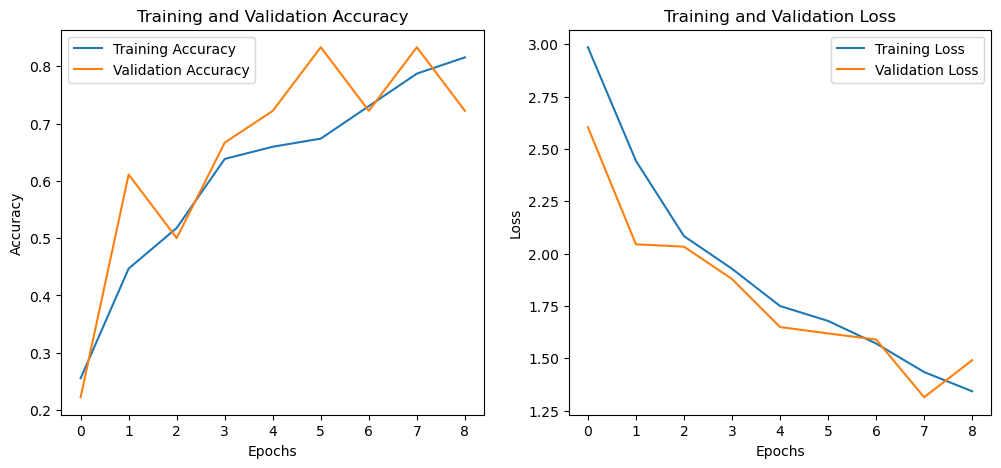

In [16]:
# Load VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False
# Add layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(len(animal_classes), activation='softmax')(x)

# Define, Compile and Train
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[early_stopping])

# Print validation metrics
final_val_loss, final_val_accuracy = model.evaluate(val_data)
print(f"\nModel training completed. Final validation loss: {final_val_loss:.4f}, Final validation accuracy: {final_val_accuracy:.4f}")



plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


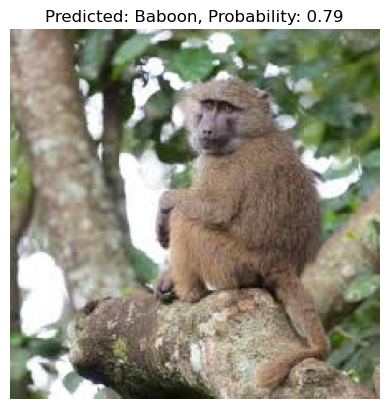

In [17]:
# Example usage
img_path = 'jackie.png'
img, predicted_label, probability = predict_image_class(model, img_path, animal_classes)
display_prediction(img, predicted_label, probability)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.1558 - loss: 3.9709 - val_accuracy: 0.1667 - val_loss: 2.7360
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.1603 - loss: 3.4734 - val_accuracy: 0.1667 - val_loss: 3.2345
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.1767 - loss: 3.4848 - val_accuracy: 0.3889 - val_loss: 2.3507
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3889 - loss: 2.3502

Model training completed. Final validation loss: 2.3502, Final validation accuracy: 0.3889


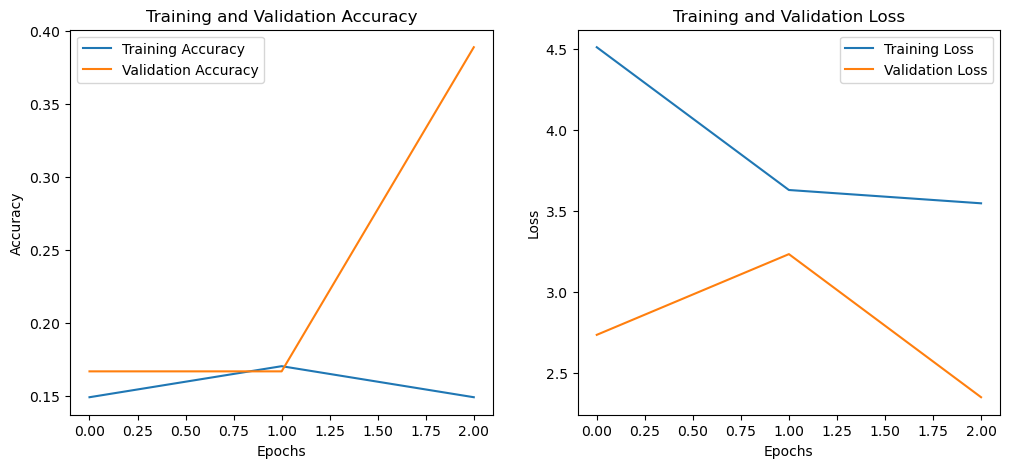

In [20]:
from keras.applications import ResNet50

# RESNET50
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers 
for layer in resnet_base_model.layers:
    layer.trainable = False

x = Flatten()(resnet_base_model.output)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(animal_classes), activation='softmax')(x)

resnet_model = Model(inputs=resnet_base_model.input, outputs=output)

resnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet_history = resnet_model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[early_stopping])

# Print final validation metrics
final_val_loss, final_val_accuracy = resnet_model.evaluate(val_data)
print(f"\nModel training completed. Final validation loss: {final_val_loss:.4f}, Final validation accuracy: {final_val_accuracy:.4f}")



# Call the function to plot training history
plot_training_history(resnet_history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


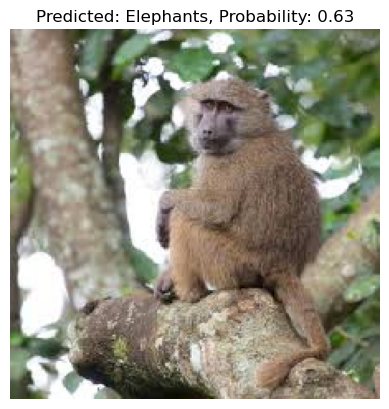

In [22]:
# Resnet Prediction

img_path = 'jackie.png'
img, predicted_label, probability = predict_image_class(resnet_model, img_path, animal_classes)
display_prediction(img, predicted_label, probability)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 10s/step - accuracy: 0.2228 - loss: 3.2341 - val_accuracy: 0.3889 - val_loss: 2.5363
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 11s/step - accuracy: 0.3450 - loss: 2.6337 - val_accuracy: 0.3333 - val_loss: 2.3881
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 12s/step - accuracy: 0.4059 - loss: 2.5048 - val_accuracy: 0.5000 - val_loss: 2.4572
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step - accuracy: 0.5058 - loss: 2.2188 - val_accuracy: 0.4444 - val_loss: 2.1696
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - accuracy: 0.5210 - loss: 2.0588 - val_accuracy: 0.6667 - val_loss: 1.8824
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - accuracy: 0.6288 - loss: 1.7782 - val_accuracy: 0.7222 - val_loss: 1.8655
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 11s/step - accuracy: 0.6295 - loss: 1.8037 - val_accuracy: 0.5556 - val_loss: 1.8947
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 10s/step - accuracy: 0.6725 - loss: 1.6215 - val_accuracy: 0.6667 - val_loss:

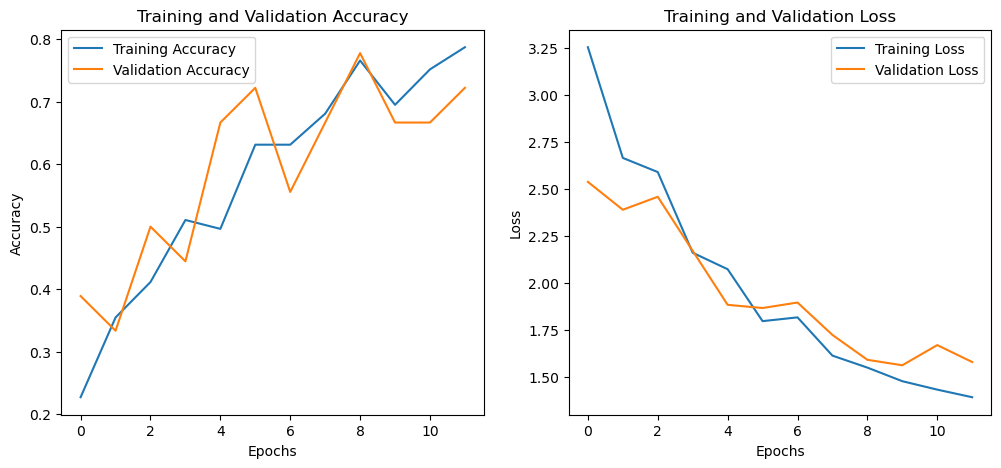

In [4]:
# VGG19

from tensorflow.keras.applications import VGG19

vgg_base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in vgg_base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(vgg_base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

x = Dropout(0.5)(x)
output = Dense(len(animal_classes), activation='softmax')(x)

vgg_model = Model(inputs=vgg_base_model.input, outputs=output)

vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
vgg_history = vgg_model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stopping])

# We're done!
final_val_loss, final_val_accuracy = vgg_model.evaluate(val_data)
print(f"\nModel training completed. Final validation loss: {final_val_loss:.4f}, Final validation accuracy: {final_val_accuracy:.4f}")



# Plots metric
plot_training_history(vgg_history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


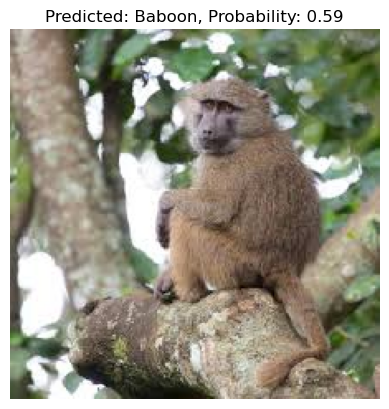

In [18]:
# Predicting with VGG19
img_path = 'jackie.png'
img, predicted_label, probability = predict_image_class(vgg_model, img_path, animal_classes)
display_prediction(img, predicted_label, probability)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.1936 - loss: 13.9755 - val_accuracy: 0.2778 - val_loss: 10.1465
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.2160 - loss: 11.0322 - val_accuracy: 0.1667 - val_loss: 8.7985
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.1542 - loss: 9.1559 - val_accuracy: 0.3333 - val_loss: 7.5875
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.2335 - loss: 7.6698 - val_accuracy: 0.1667 - val_loss: 6.2635
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.1958 - loss: 6.6738 - val_accuracy: 0.3889 - val_loss: 5.1663
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.2548 - loss: 5.1558 - val_accuracy: 0.3333 - val_loss: 4.4266
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.2648 - loss: 4.5409 - val_accuracy: 0.4444 - val_loss: 3.8590
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.2756 - loss: 3.9483 - val_accuracy: 0.3889 - val_loss: 3.43

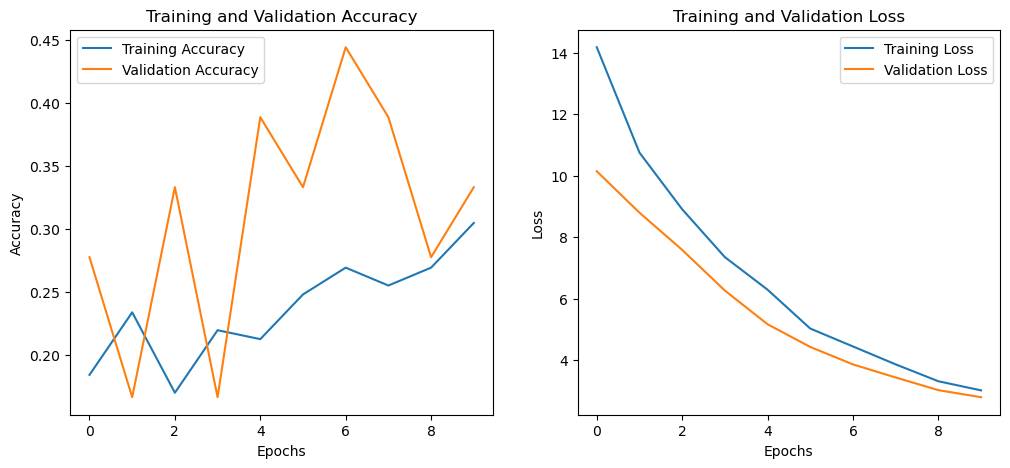

In [10]:
# RESNET with L2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers

resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_base_model.layers:
    layer.trainable = False

x = Flatten()(resnet_base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(len(animal_classes), activation='softmax')(x)

resnet_model_l2 = Model(inputs=resnet_base_model.input, outputs=output)

resnet_model_l2.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet_history_l2 = resnet_model_l2.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stopping])

# validation metrics
final_val_loss, final_val_accuracy = resnet_model_l2.evaluate(val_data)
print(f"\nModel training completed. Final validation loss: {final_val_loss:.4f}, Final validation accuracy: {final_val_accuracy:.4f}")




plot_training_history(resnet_history_l2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


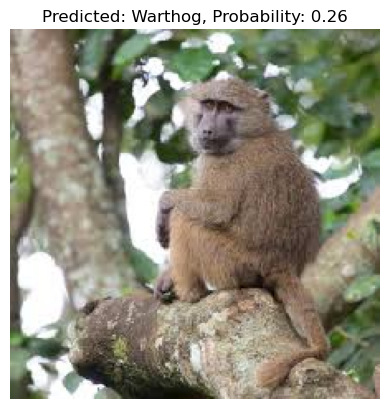

In [11]:
# Predicting with RESNET_L2
img_path = 'jackie.png'
img, predicted_label, probability = predict_image_class(resnet_model_l2, img_path, animal_classes)
display_prediction(img, predicted_label, probability)

In [32]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on validation data
val_data.reset() 


true_labels = val_data.classes

class_labels = list(val_data.class_indices.keys())

models = {"vgg16": model, "vgg19": vgg_model, "resnet": resnet_model}

# classification report
for model_name, model_instance in models.items():
    predictions = model_instance.predict(val_data)
    predicted_classes = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(true_labels, predicted_classes)
    loss, _ = model_instance.evaluate(val_data, verbose=0)
    
    report_dict = classification_report(true_labels, predicted_classes, target_names=class_labels, output_dict=True)
    
    precision = report_dict['weighted avg']['precision']
    recall = report_dict['weighted avg']['recall']
    f1_score = report_dict['weighted avg']['f1-score']
    
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Metrics for vgg16:
Accuracy: 0.7222
Loss: 1.6525
Precision: 0.8500
Recall: 0.7222
F1 Score: 0.7269
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Metrics for vgg19:
Accuracy: 0.7778
Loss: 1.5676
Precision: 0.8630
Recall: 0.7778
F1 Score: 0.7754
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Metrics for resnet:
Accuracy: 0.3333
Loss: 2.3637
Precision: 0.1645
Recall: 0.3333
F1 Score: 0.2103
--------------------------------------------------


/home/kira/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kira/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kira/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
model.save('models/vgg16_model.h5')
vgg_model.save('models/vgg19_model.h5')
resnet_model.save('models/resnet_model.h5')